In [11]:
import sys
sys.path.append("/home/julian/repositories")

from wingshape import WingShape
from parapolygraph import ParamPolyGraph
import numpy, math

wingshape = WingShape("P7-211221-XYZ geometry.csv")        
parapolygraph = ParamPolyGraph(wingshape, "test7.json", splineweight=0.8, legsampleleng=0.003)


In [38]:
#
# Derive the polygons from the network of nodes in UV space ( --> XYZ space by function wingshape.seval )
#
from barmesh.basicgeo import I1, Partition1, P2

parapolygraph.splineinterplegsdata()
polysnodes = parapolygraph.derivepolygons()
surfacemeshes = [ ]
for i, polynodes in enumerate(polysnodes):
    polyloop = parapolygraph.splinedpolypoints(polynodes)
    polyloopW = [ wingshape.seval(p)  for p in polyloop ]
    surfacemesh = { "polynodes":polynodes, 
                    "polyloop":polyloop,
                    "plurg":I1.AbsorbList(p[0]  for p in polyloop), 
                    "plvrg":I1.AbsorbList(p[1]  for p in polyloop),
                    "plcentre":sum(polyloop, start=P2(0,0))*(1.0/len(polyloop)), 
                    "polyloopW":polyloopW 
                  }
    surfacemeshes.append(surfacemesh)


In [55]:
#
# We need to identify and number the polygons (and some of the edges) appropriately 
# So that we can make the differential offsetting of them
#

#surfacemeshes.sort(key=lambda x: -x["plcentre"].v + x["plcentre"].u*0.05)
#print("{%s}" % ",\n\t".join("'s%d':%s" % (i, "(%.3f, %.3f)" % surfacemesh["plcentre"])  for i, surfacemesh in enumerate(surfacemeshes) ))

patchnamelookups = {   
    's0':(0.851, 0.865),
    's1':(3.907, 0.864),
    's2':(0.207, 0.106),
    's3':(0.622, 0.106),
    's4':(1.045, 0.106),
    's5':(1.481, 0.106),
    's6':(2.158, 0.106),
    's7':(3.484, 0.106),
    's8':(4.734, 0.106),
    's9':(5.612, 0.106),
    's10':(0.851, -0.294),
    's11':(3.907, -0.294),
    's12':(0.415, -0.913),
    's13':(1.266, -0.913),
    's14':(3.394, -0.827),
    's15':(4.082, -1.073) }

for surfacemesh in surfacemeshes:
    surfacemesh["patchname"] = min(((surfacemesh["plcentre"] - P2(*p)).Len(), name)  for name, p in patchnamelookups.items())[1]
assert len(set(surfacemesh["patchname"]  for surfacemesh in surfacemeshes)) == len(patchnamelookups)


In [79]:
#
# Calculate the offsets of the polygons based on a common rectangular subdivision spacing xpartA, xpartB
#

radoffset = 0.006
uspacing, vspacing = 0.02, 0.02

from barmesh.tribarmes import TriangleBarMesh, TriangleBar, MakeTriangleBoxing
from wingflatten_barmeshfuncs import ImplicitAreaBallOffsetOfClosedContour
#from barmesh import implicitareaballoffset
from wingflatten_barmeshfuncs import MakeRectBarmeshForWingParametrization
from barmesh.barmeshslicer import BarMeshSlicer
from barmesh.mainfunctions import nodewithinpairs, BarMeshContoursN
from barmesh.basicgeo import I1, Partition1

urgA, vrgA = I1(*wingshape.urange).Inflate(0.06), I1(*wingshape.vrange).Inflate(0.06)
xpartA = Partition1(urgA.lo, urgA.hi, int(urgA.Leng()/uspacing + 2))
ypartA = Partition1(vrgA.lo, vrgA.hi, int(vrgA.Leng()/vspacing + 2))

def SubPartition(part, vlo, vhi):
    res = Partition1(0, 1, 2)
    ilo, ihi = part.GetPartRange(vlo, vhi)
    res.vs = part.vs[ilo:ihi+2]
    res.lo, res.hi = res.vs[0], res.vs[-1]
    res.nparts = ihi - ilo + 1
    assert len(res.vs) == res.nparts + 1
    assert res.lo < vlo < vhi < res.hi, (res.lo , vlo , vhi , res.hi)
    return res

def barmeshoffset(polyloop, polyloopW, radoffset, uspacing, vspacing):
    iaoffset = ImplicitAreaBallOffsetOfClosedContour(polyloopW, polyloop)
    
    urg = I1.AbsorbList(p[0]  for p in polyloop).Inflate(0.05)
    vrg = I1.AbsorbList(p[1]  for p in polyloop).Inflate(0.05)
    xpart = SubPartition(xpartA, urg.lo, urg.hi)
    ypart = SubPartition(ypartA, vrg.lo, vrg.hi)
    
    bm = MakeRectBarmeshForWingParametrization(wingshape, xpart, ypart)
    rd2 = max(uspacing, vspacing, radoffset*2) + 0.01
    contourdelta = min(uspacing, vspacing)*0.2
    bms = BarMeshSlicer(bm, iaoffset, rd=radoffset, rd2=rd2, contourdotdiff=0.95, contourdelta=contourdelta, lamendgap=0.001, strictlyplanarbarmesh=False)

    #bms.initializecutsanddistances()
    bms.fullmakeslice()
    return bm

for i in range(len(surfacemeshes)):
    print("\nStarting", i)
    surfacemesh = surfacemeshes[i]
    polyloop, polyloopW = surfacemesh["polyloop"], surfacemesh["polyloopW"]
    surfacemesh["barmeshoffset"] = barmeshoffset(polyloop, polyloopW, radoffset=radoffset, uspacing=0.02, vspacing=0.02)



Starting 0
make triangle boxing at 0.06969896047048123
make triangle boxing at 0.20506367818094537
MakePointZoneRFS done on 5487 nodes
do splitbarsdirectionchangesR on 10822 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  278
nsegs: 297 bad: 0 working: 0
95 [10, 20, 20, 5, 10, 20, 0, 0, 5, 5, 0, 0, 0, 0, 0]

Starting 1
make triangle boxing at 0.019120965004800473
make triangle boxing at 0.20506367818094537
MakePointZoneRFS done on 13452 nodes
do splitbarsdirectionchangesR on 26617 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  550
nsegs: 566 bad: 0 working: 0
76 [10, 13, 15, 10, 15, 5, 5, 0, 0, 3, 0, 0, 0, 0, 0]

Starting 2
make triangle boxing at 0.0670101443713736
make triangle boxing at 0.08264884338318335
MakePointZoneRFS done on 896 nodes
do splitbarsdirectionchangesR on 1732 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  94
nsegs: 111 bad: 0 working: 0
85 [15, 15, 15, 15, 10, 5, 5, 5, 0, 0, 0, 0]

Starting 3
make triangle b

In [81]:
from barmesh import barmesh
from wingflatten_barmeshfuncs import findallnodesandpolys, cpolytriangulate

for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    bm = surfacemesh["barmeshoffset"]
    contsN, topbars = BarMeshContoursN(bm, barmesh.PZ_BEYOND_R)
    assert len(contsN) == 1
    surfacemesh["offsettopbar"] = topbars[0]
    outercont = contsN[0]
    outercont.append(outercont[0])
    surfacemesh["offsetloopuv"] = [n.sp for n in outercont]
    surfacemesh["offsetlooppts"] = [n.p for n in outercont]
    tnodes, cpolys = findallnodesandpolys(bm)
    ptsF = [ node.sp  for node in tnodes ]
    surfacemesh["pts"] = numpy.array([ node.p  for node in tnodes ])
    surfacemesh["uvpts"] = numpy.array(ptsF)
    tris = [ ]
    for cpoly in cpolys:
        tris.extend(cpolytriangulate(ptsF, cpoly))
    surfacemesh["tris"] = numpy.array(tris)
    surfacemesh["offsetloopI"] = [n.i for n in outercont]
    print(i, len(ptsF), len(tris))


0 4874 9449
1 12347 24126
2 678 1243
3 679 1243
4 678 1241
5 712 1304
6 1335 2503
7 2499 4744
8 1145 2138
9 1513 2851
10 1611 3000
11 4076 7660
12 2276 4353
13 2334 4463
14 7080 13716
15 4921 9148


In [82]:
#
# Call the surface flattener (produces surfacemesh["fpts"], "triareas", "ftriareas")
#

#freecadappimage = "/home/timbo/software/FreeCAD_0.19-24054-Linux-Conda_glibc2.12-x86_64.AppImage"
# fetch from: wget https://github.com/FreeCAD/FreeCAD/releases/download/0.19_pre/FreeCAD_0.19-24267-Linux-Conda_glibc2.12-x86_64.AppImage
freecadappimage = "freecad"   # nixos install

from parapolygraph import trimeshesflattener
trimeshesflattener(surfacemeshes, freecadappimage)


>>> >>> >>> >>> >>> >>> >>> >>> >>> ... ... ... ... ... ... ... ... >>> >>> 
>>> 

[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]
mesh (pts=4874, tris=9449) flattened
mesh (pts=12347, tris=24126) flattened
mesh (pts=678, tris=1243) flattened
mesh (pts=679, tris=1243) flattened
mesh (pts=678, tris=1241) flattened
mesh (pts=712, tris=1304) flattened
mesh (pts=1335, tris=2503) flattened
mesh (pts=2499, tris=4744) flattened
mesh (pts=1145, tris=2138) flattened
mesh (pts=1513, tris=2851) flattened
mesh (pts=1611, tris=3000) flattened
mesh (pts=4076, tris=7660) flattened
mesh (pts=2276, tris=4353) flattened
mesh (pts=2334, tris=4463) flattened
mesh (pts=7080, tris=13716) flattened
mesh (pts=4921, tris=9148) flattened
[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]



<IPython.core.display.Javascript object>


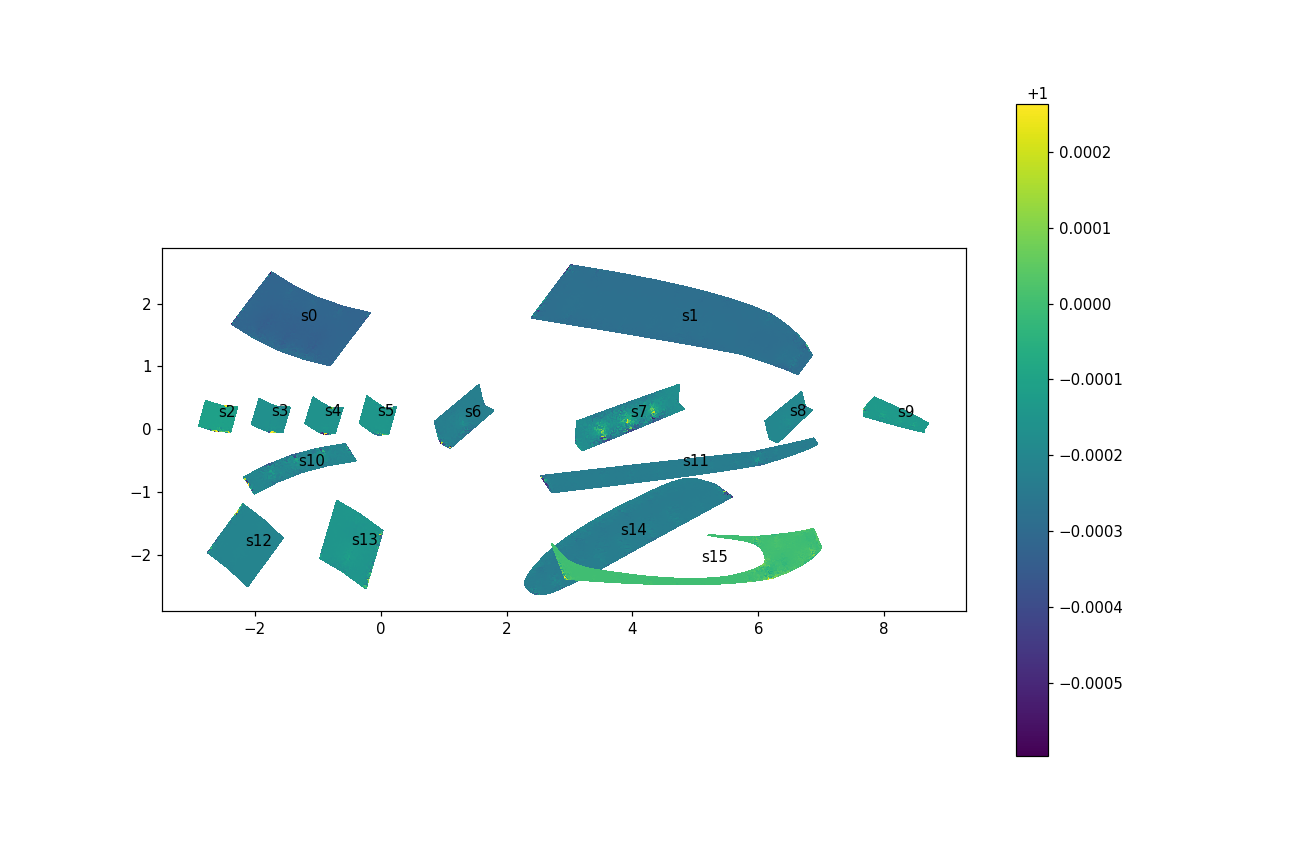

In [196]:
#
# Rotate and move the flat pieces produce the exploded diagram
#
%matplotlib notebook


def orientation(ptfs, polyi):
    ptfs = surfacemesh["uvpts"]
    #ptfs = surfacemesh["fpts"]
    polyi = surfacemesh["offsetloopI"]
    jbl, ptbl = min(enumerate(ptfs[i]  for i in polyi), key=lambda X:(X[1][1], X[1][0]))
    ptblFore = ptfs[polyi[(jbl+1)%len(polyi)]]
    ptblBack = ptfs[polyi[(jbl+len(polyi)-1)%len(polyi)]]
    angFore = P2(ptblFore[0]-ptbl[0], ptblFore[1]-ptbl[1]).Arg()
    angBack = P2(ptblBack[0]-ptbl[0], ptblBack[1]-ptbl[1]).Arg()
    return (angBack < angFore)

for surfacemesh in surfacemeshes:
    ptsF = surfacemesh["fpts"]
    offsetloopuv = surfacemesh["offsetloopuv"]
    offsetloopptsF = [ P2(ptsF[i][0], ptsF[i][1])  for i in surfacemesh["offsetloopI"] ]
    offsetloopuvCentre = sum(offsetloopuv, start=P2(0,0))*(1.0/len(offsetloopuv))
    offsetloopptsFCentre = sum(offsetloopptsF, start=P2(0,0))*(1.0/len(offsetloopptsF))
    voff = offsetloopuvCentre - offsetloopptsFCentre
    
    #print(orientation(surfacemesh["uvpts"], surfacemesh["offsetloopI"]), orientation(surfacemesh["fpts"], surfacemesh["offsetloopI"]))

    i0 = surfacemesh["offsetloopI"][20]
    v = P2(*surfacemesh["uvpts"][i0]) - offsetloopuvCentre
    vF = P2(*surfacemesh["fpts"][i0]) - offsetloopptsFCentre
    xv = P2.ZNorm(P2(P2.Dot(vF, v), P2.Dot(vF, P2.APerp(v))))
    yv = -P2.APerp(xv)
    explodev = (offsetloopuvCentre - P2(3, 0))
    def transF(p):
        p0 = p - offsetloopptsFCentre
        return xv*p0[0] + yv*p0[1] + offsetloopuvCentre + explodev
    surfacemesh["fptsT"] = numpy.array([ transF(p)  for p in surfacemesh["fpts"] ])
    surfacemesh["textpos"] = offsetloopuvCentre + explodev

%matplotlib notebook
plt.figure(figsize=(12,8))

for surfacemesh in surfacemeshes:
    fpts = surfacemesh["fptsT"]
    X = fpts[:,0]
    Y = fpts[:,1]
    areachange = surfacemesh["triareas"]/surfacemesh["ftriareas"]
    plt.tripcolor(X, Y, surfacemesh["tris"], facecolors=areachange)
    plt.text(surfacemesh["textpos"][0], surfacemesh["textpos"][1], surfacemesh["patchname"])
    
plt.gca().autoscale()
plt.gca().set_aspect("equal")
plt.colorbar()


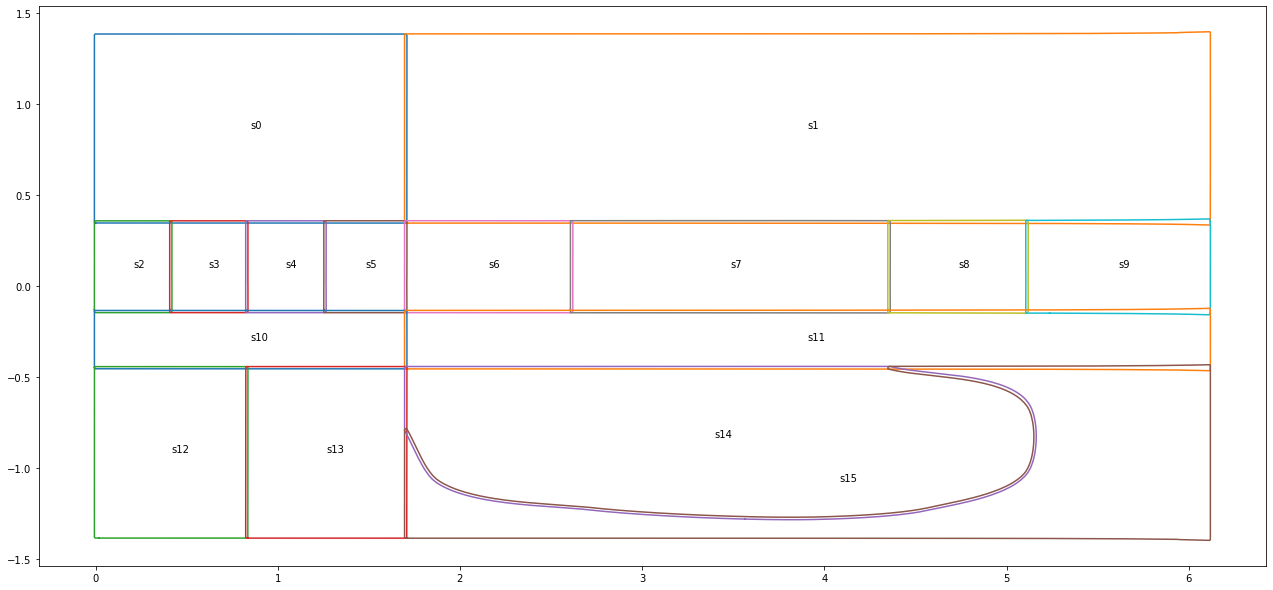

In [85]:
%matplotlib inline 

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(figsize=(22,18))
for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    sps = surfacemesh["offsetloopuv"]
    plt.plot([sp[0] for sp in sps], [sp[1] for sp in sps])
    plt.gca().text(surfacemesh["plcentre"][0], surfacemesh["plcentre"][1], surfacemesh["patchname"])
plt.gca().autoscale()
plt.gca().set_aspect("equal")


<IPython.core.display.Javascript object>


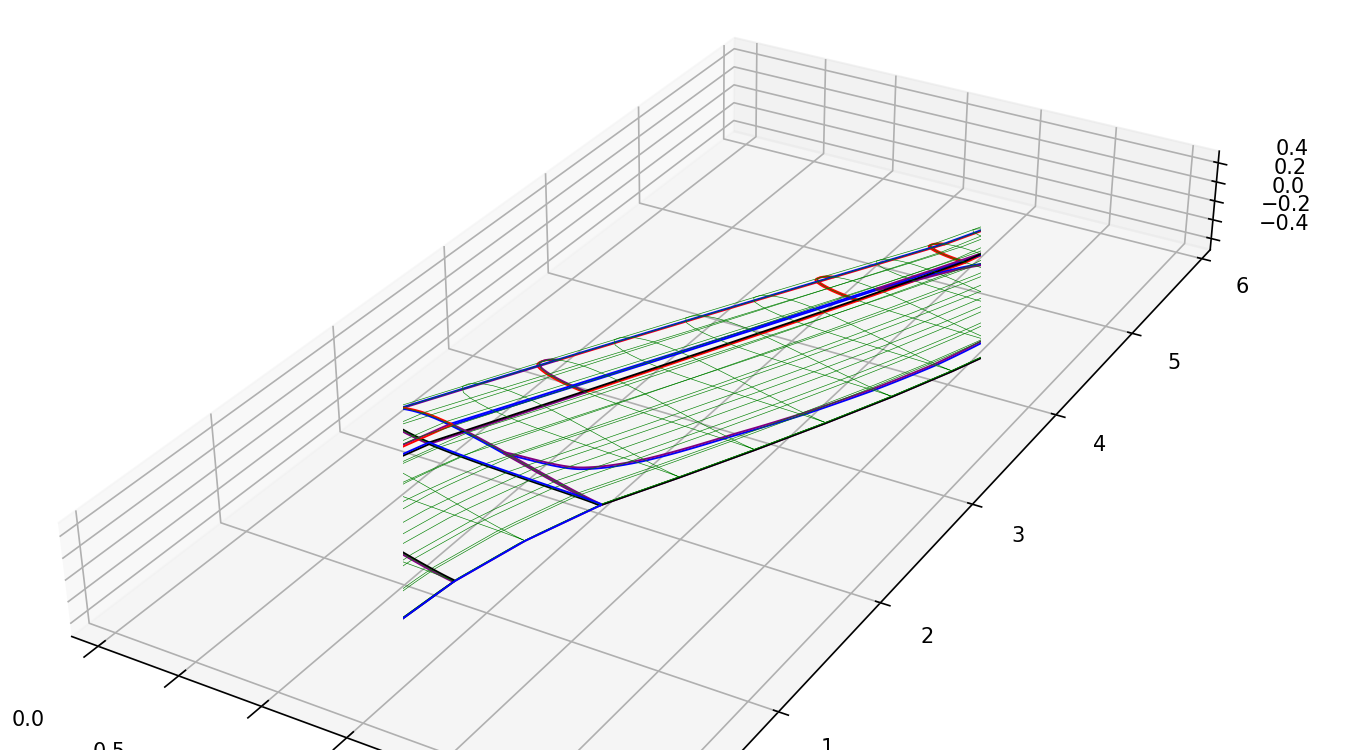

(0.0, 6.0)

In [21]:
%matplotlib notebook

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy

def flipyz(p):
    return (p.x, p.z, p.y)

fig = plt.figure(figsize=(9,5))
ax3d = fig.add_subplot(1,1,1, projection='3d')
ax3d.set_box_aspect([1,2,0.2], zoom=2.3)

ax3d.add_collection(Line3DCollection(wingshape.linesegmentnetflipyz(flipyz), color="green", linewidth=0.3))

cols = ["red", "blue", "purple", "black"]
for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    ps = surfacemesh["offsetlooppts"]
    segpolys = [ ]
    segpolys.append([flipyz(p)  for p in ps])
    lp3d = Line3DCollection(segpolys, color=cols[0], linewidth=0.9)
    ax3d.add_collection(lp3d)
    cols = cols[1:]+[cols[0]]
ax3d.set_aspect('auto')
ax3d.set_clip_on(False)
ax3d.autoscale_view()
ax3d.set_xlim3d(-0.1, 3.1)
ax3d.set_zlim3d(-0.5, 0.5)
ax3d.set_ylim3d(0, 6)